Epoch [1/100], Step [100/300], Loss: 0.2151
Epoch [1/100], Step [200/300], Loss: 0.2205
Epoch [1/100], Step [300/300], Loss: 0.0625
Epoch [2/100], Step [100/300], Loss: 0.1912
Epoch [2/100], Step [200/300], Loss: 0.1202
Epoch [2/100], Step [300/300], Loss: 0.0930
Epoch [3/100], Step [100/300], Loss: 0.1061
Epoch [3/100], Step [200/300], Loss: 0.1118
Epoch [3/100], Step [300/300], Loss: 0.0497
Epoch [4/100], Step [100/300], Loss: 0.0864
Epoch [4/100], Step [200/300], Loss: 0.0604
Epoch [4/100], Step [300/300], Loss: 0.0749
Epoch [5/100], Step [100/300], Loss: 0.1290
Epoch [5/100], Step [200/300], Loss: 0.0510
Epoch [5/100], Step [300/300], Loss: 0.0631
Epoch [6/100], Step [100/300], Loss: 0.1094
Epoch [6/100], Step [200/300], Loss: 0.0457
Epoch [6/100], Step [300/300], Loss: 0.0912
Epoch [7/100], Step [100/300], Loss: 0.0474
Epoch [7/100], Step [200/300], Loss: 0.0569
Epoch [7/100], Step [300/300], Loss: 0.0709
Epoch [8/100], Step [100/300], Loss: 0.0110
Epoch [8/100], Step [200/300], L

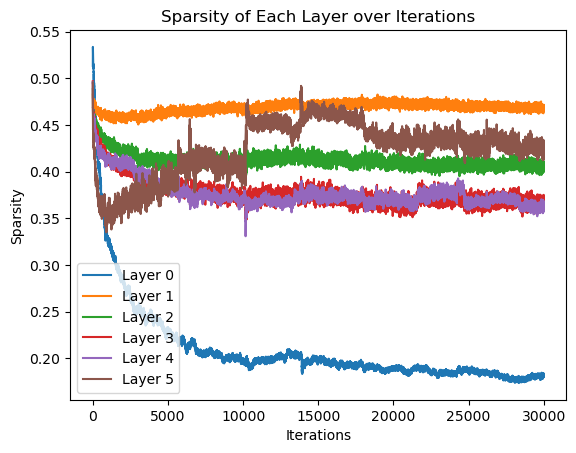

Accuracy of the network on the 10000 test images: 98.4 %


In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 定义神经网络模型
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, ini_bias):
        super(NeuralNet, self).__init__()
        linear_with_bias = nn.Linear(input_size, hidden_size, bias=True)
        nn.init.constant_(linear_with_bias.bias, ini_bias)
        self.layers = nn.ModuleList([linear_with_bias])
        for _ in range(num_layers-1):
            hidden_with_bias = nn.Linear(hidden_size, hidden_size, bias=True)
            nn.init.constant_(hidden_with_bias.bias, ini_bias)
            self.layers.append(hidden_with_bias)

        self.layers.append(nn.Linear(hidden_size, num_classes))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.batchnorm(self.relu(layer(x)))
        x = self.layers[-1](x)
        return x

# 超参数设置
input_size = 784  # MNIST 图像大小为 28x28，展平后为 784
hidden_size = 1024 # 隐藏层大小
num_layers = 6  # 线性层数量
num_classes = 10  # 类别数
num_epochs = 100
batch_size = 200
learning_rate = 5e-3
ini_bias = 0

# 加载 MNIST 数据集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# 数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型、损失函数和优化器
model = NeuralNet(input_size, hidden_size, num_layers, num_classes, ini_bias)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
total_step = len(train_loader)
layer_outputs = [[] for _ in range(num_layers)]
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        
        # 前向传播和计算损失
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
        for j in range(num_layers):
            images_ac = torch.relu(model.layers[j](images))
            images = nn.BatchNorm1d(hidden_size)(images_ac)
            zero_count = (images_ac > 0).sum().item()  # 激活函数后为0的个数
            total_count = images.numel()  # 总元素数
            zero_ratio = zero_count / total_count  # 计算比例
            layer_outputs[j].append(zero_ratio)

# 可视化结果
iter = range(len(layer_outputs[0]))
for row in range(len(layer_outputs)):
    plt.plot(iter, layer_outputs[row][:], label=f"Layer {row}")

plt.xlabel("Iterations")
plt.ylabel("Sparsity")
plt.title("Sparsity of Each Layer over Iterations")
plt.legend()
plt.show()



# 测试模型
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
